123
analyzing: ../state/execs/123.exec/
log.file	state/execs/123.exec/log

Simulator.reqParams	grammar=1&cite=1&learn=1&logging=0

Simulator.logFiles	./shrdlurn/queries/sidaw.json.log ./shrdlurn/queries/qualifier1-0118.json ./shrdlurn/queries/qualifier3-0201.json

Average of percent of status Nothing is 0.040459
Average of percent of status Induced is 0.281521
Average of percent of status Core is 0.678020
Average of percent of status Nothing is 0.215721
Average of percent of status Induced is 0.263034
Average of percent of status Core is 0.521245
Average of accuracy is 0.770982
Average of recall is 0.840704
Average of stats.size is 3.587312


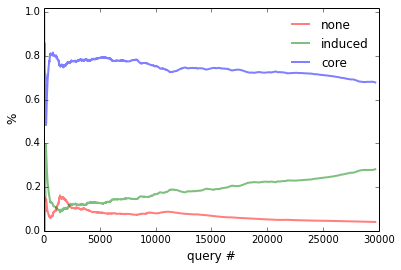

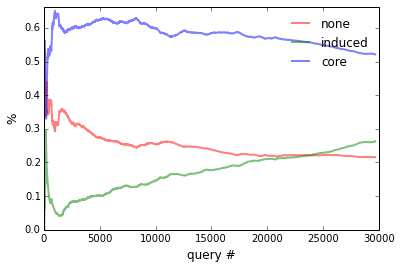

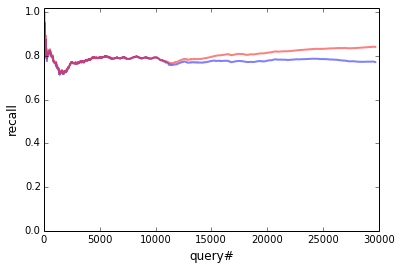

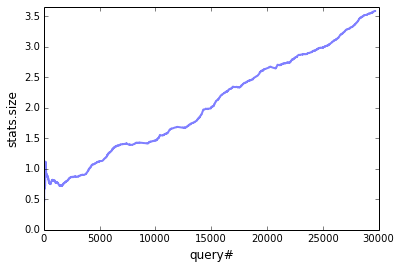

In [16]:
import csv
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import subprocess
%matplotlib inline  


def plot_reset():
    global p
    p = {'color': 'r', 'linewidth': 2, 'alpha':0.5}
                       #, 'marker':'*', 'markersize':0.3}
plot_reset()
def savefig(filename = 'fig.pdf'):
    plt.savefig(os.path.join(execPath,filename) ,  bbox_inches="tight")

def plot_cumavg(x, y, xlabel='query#', ylabel='recall', title=None):
    y_cum = np.cumsum(y).tolist()
    #print accepts_np[:,1]
    y_cumavg = [cum / float(count+1) for count,cum in enumerate(y_cum)]
    #N = 500;
    #y_cumavg = np.convolve(np.array(y), np.ones((N,))/N, mode='same').tolist()

    #print accept_rate 
    
    #plt.scatter(means_baseline[0:], means[0:], s=colors, alpha=0.8, c='r')
    plt.plot(x, y_cumavg, **p)
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    # plt.xlim(0, 0.65)
    plt.ylim(0, max(y_cumavg)*1.02)
    
    xp = np.linspace(0, 0.65, 300)
    
    #plt.gca().set_aspect('equal', adjustable='box')
    plottitle = title if title is not None else '%s_vs_%s.pdf' % (xlabel, ylabel)
    # plt.savefig(os.path.join(execPath,plottitle) ,  bbox_inches="tight")
    
def print_avg(x, name = 'unnamed'):
    print 'Average of %s is %f' % (name, reduce(lambda a,b: a+b, x) / float(len(x)));
    
with open('../state/lastExec', 'rb') as lastExec:
    lastExecInd = lastExec.readline().strip()
print lastExecInd
     
rows = []; 
execInd = lastExecInd;
execPath = '../state/execs/%s.exec/' % execInd
print 'analyzing: ' + execPath
def printOptions():
    with open(os.path.join(execPath,'options.map')) as optionsfile:
        opts = filter(lambda l: 'file' in l or 'logFiles' in l  or 'reqParams' in l, optionsfile.readlines());
        for opt in opts: print opt
    # egrep 'file|Simulator'
printOptions()

with open('../state/execs/%s.exec/plotInfo.json' % execInd, 'rb') as jsonfile:
    json_lines = jsonfile.readlines()
    
rows = [json.loads(l) for l in json_lines]
# accepts = [[r['queryCount'], 1 if r['stats.rank']>=0 else 0] for r in rows if r['stats.type'] == 'accept'];


def precent_status(filtered_rows, status = 'Core'):
    query_counts = [r['queryCount'] for r in filtered_rows]
    is_status = [1 if r['stats.status'] == status else 0 for r in filtered_rows]
    print_avg(is_status, 'percent of status ' + status)
    plot_cumavg(query_counts, is_status, xlabel='query #', ylabel='%');


def plotCoreInducedNone(filtered_rows):
    p['color'] = 'r'; p['label'] = 'none';
    precent_status(filtered_rows, status = 'Nothing');
    p['color'] = 'g'; p['label'] = 'induced';
    precent_status(filtered_rows,status = 'Induced');
    p['color'] = 'b'; p['label'] = 'core';
    precent_status(filtered_rows, status = 'Core');
    plt.legend(frameon=False)
    
plt.figure()
plotCoreInducedNone([r for r in rows if r['stats.type'] == 'accept'])
savefig('parse_status_accepted.pdf')

plt.figure()
plotCoreInducedNone([r for r in rows if r['stats.type'] == 'q'])
savefig('parse_status_q.pdf')

def simple_acc():
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept']
    query_counts = [r['queryCount'] for r in filtered_rows]
    accepts = [1 if r['stats.rank']==0 else 0 for r in filtered_rows]
    plot_cumavg(query_counts, accepts, xlabel='query#', ylabel='accuracy');
    print_avg(accepts, 'accuracy')
plt.figure()
simple_acc()

def simple_recall():
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept']
    query_counts = [r['queryCount'] for r in filtered_rows]
    recall = [1 if r['stats.rank']>=0 else 0 for r in filtered_rows]
    plot_cumavg(query_counts, recall, xlabel='query#', ylabel='recall');
    print_avg(recall, 'recall')
p['color'] = 'r'
simple_recall()

def average_stat(stat = 'stats.size', type = 'q'):
    filtered_rows = [r for r in rows if r['stats.type'] == type]
    query_counts = [r['queryCount'] for r in filtered_rows]
    stats = [r[stat] for r in filtered_rows]
    plot_cumavg(query_counts, stats, xlabel='query#', ylabel=stat);
    print_avg(stats, stat)
plt.figure()
p['color'] = 'b'
average_stat(stat = 'stats.size')




In [4]:
with open('../state/lastExec', 'rb') as lastExec:
    lastExecInd = lastExec.readline().strip()
print lastExecInd

rows = []; 
execInd = lastExecInd;
with open('../state/execs/%s.exec/plotInfo.json' % execInd, 'rb') as jsonfile:
    json_lines = jsonfile.readlines()
    
rows = [json.loads(l) for l in json_lines]

accept_all = [r for r in rows if r['stats.type']=='accept']
accept_nothing = [r for r in rows if r['stats.type']=='accept' and r['stats.status']=='Nothing']
print 'accepts: %d / %d totallines: %d' % (len(accept_nothing), len(accept_all), len(json_lines))

for r in accept_nothing[:5]:
    print '{q}'.format(**r)
    
sorted(reduce(top_users, rows, {}).items(), key=lambda x: -x[1])

104
accepts: 33 / 5781 totallines: 15561
(:accept "select left 6 times" "(:loop (number 6) (: select (call adj left)))")
(:accept "select right 2 times" "(:loop (number 2) (: select (call adj right)))")
(:accept "select front; select left 2 times" "(:s (: select (call adj front)) (:loop (number 2) (: select (call adj left))))")
(:accept "select left of this four times" "(:loop (number 4) (: select (call adj left this)))")
(:accept "select right 3 times; select back; add red plate height 3" "(:s (:s (:loop (number 3) (: select (call adj right))) (: select (call adj back))) (:loop (number 3) (:s (:s (:loop (number 3) (:s (: add red here) (: select (call adj top this)))) (:loop (number 3) (: select (call adj bot this)))) (: select (call adj left)))))")


NameError: name 'top_users' is not defined

KeyError: 'sessionId'

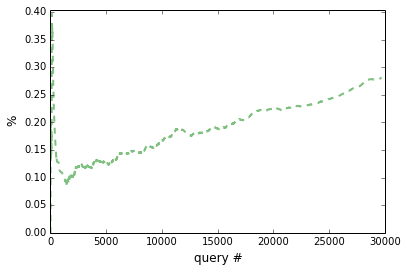

In [23]:
def precent_status_user(filtered_rows):
    query_counts = [r['queryCount'] for r in filtered_rows]
    is_status = [1 if r['stats.status'] == 'Induced' else 0 for r in filtered_rows]
    plot_cumavg(query_counts, is_status, xlabel='query #', ylabel='%');

    # utilities
def top_users(counts, line):
    id = 'sessionId'
    if line[id] in counts:
        counts[line[id]] = counts[line[id]] + 1
    else:
        counts[line[id]] = 1
    return counts

rows_to_count = [r for r in rows if r['stats.type'] == 'accept']
ranked_users = sorted(reduce(top_users, rows_to_count[5000:], {}).items(), key=lambda x: -x[1])

plt.figure()
topnum = 5;
plot_reset()
p['alpha'] = 0.5;
p['label'] = 'all'; 
p['linestyle'] = '--';
p['color'] = 'g'; precent_status_user([r for r in rows if r['stats.type'] == 'accept']);    

colors = ['c', 'r', 'm', 'y', 'b']
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 2;

for g in enumerate(ranked_users[0:5]):
    # (0, (u'AMT_A1HKYY6XI2OHO1', 2830))
    p['label'] = '#%d' % (g[0]+1);
    #plotsetting['alpha'] = 1-float(g[0])/topnum;
    p['color'] = colors[g[0]];
    # print plotsetting['color']
    precent_status_user([r for r in rows if r['stats.type'] == 'accept' and r['sessionId'] == g[1][0]])
    print g

plt.ylim(-0.1, 0.5)
plt.legend(frameon=False, loc='lower right')
savefig('parse_status_topuser.pdf');

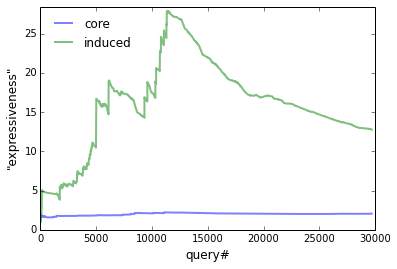

In [19]:
def expressivity(status = 'Core'):
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status'] == status]
    query_counts = [r['queryCount'] for r in filtered_rows]
    len_formula = [r['stats.len_formula'] for r in filtered_rows]
    len_utterance = [r['stats.len_utterance'] for r in filtered_rows]
    form_per_q = [float(ls[0])/ls[1] for ls in zip(len_formula, len_utterance)]
    plot_cumavg(query_counts, form_per_q, xlabel='query#', ylabel='"expressiveness"');

    #plot_cumavg(query_counts, len_utterance, xlabel='query#', ylabel='length');
    #print_avg(len_formula, 'formula length')
plt.figure()
plot_reset()
p['color'] = 'b'; p['label'] = 'core'; expressivity('Core')
p['color'] = 'g'; p['label'] = 'induced'; expressivity('Induced')
plt.legend(frameon=False, loc='upper left')
savefig('expressiveness.pdf')


In [18]:
def expressivity_by_users(filtered_rows):
    query_counts = [r['queryCount'] for r in filtered_rows]
    len_formula = [r['stats.len_formula'] for r in filtered_rows]
    len_utterance = [r['stats.len_utterance'] for r in filtered_rows]
    form_per_q = [float(ls[0])/ls[1] for ls in zip(len_formula, len_utterance)]
    plot_cumavg(query_counts, form_per_q, xlabel='query#', ylabel='"expressiveness"');

plot_reset()
plt.figure()
p['alpha'] = 0.5;
p['label'] = 'all'; 
p['linestyle'] = '--';
p['color'] = 'g'; 
expressivity_by_users([r for r in rows if r['stats.type'] == 'accept' ])
    
colors = ['c', 'r', 'm', 'y', 'b']
plot_reset()
p['alpha'] = 1;
rows_to_count = [r for r in rows if r['stats.type'] == 'accept']
ranked_users = sorted(reduce(top_users, rows_to_count, {}).items(), key=lambda x: -x[1])
for g in enumerate(ranked_users[0:5]):
    print g
    p['label'] = '#%d' % (g[0]+1);
    p['color'] = colors[g[0]];
    expressivity_by_users([r for r in rows if r['stats.type'] == 'accept' \
                     and r['sessionId'] == g[1][0]])

plt.ylim([0,10])
plt.legend(frameon=False, loc='upper left')
savefig('expressiveness_by_user.pdf')

ZeroDivisionError: float division by zero